In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from lightgbm import LGBMClassifier

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# 1. Đọc dữ liệu
df_train = pd.read_parquet('train.parquet')
df_valid = pd.read_parquet('validation.parquet')
df_test  = pd.read_parquet('test.parquet')



In [3]:
# 2. Cột loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

CHIA TAP DU LIEU 
train : val : test = 6:2:2

TRAIN LGBM

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X

In [110]:
SEED = 42 
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'learning_rate': 0.085,
    'boosting_type':    'gbdt',
    'random_state':     SEED,
    'lambda_l1':        0.08758718919397321,
    'lambda_l2':        0.0039689175176025465,
    'learning_rate':    0.03231007103195577,
    'max_depth':        4,
    'num_leaves':       20,
    'colsample_bytree': 0.8329551585827726,
    'colsample_bynode': 0.4025961355653304,
    'bagging_fraction': 0.7738954452473223,
    'bagging_freq':     4,
    'min_data_in_leaf': 85,
   # 'scale_pos_weight': 2.7984184778875543,
    'n_estimators' : 1500
    # 'device': 'gpu'
}


In [120]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)
# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED)

# Tính toán scale_pos_weight để xử lý mất cân bằng dữ liệu
class_imbalance_ratio = sum(y == 0) / sum(y == 1)
scale_pos_weight = class_imbalance_ratio  # Tỷ lệ giữa lớp âm và lớp dương

# Khởi tạo mô hình CatBoost với các siêu tham số tốt nhất
model = lgbm.LGBMClassifier(**lgb_params)

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

In [121]:


# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])
# Định nghĩa hàm custom metric
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X_train, y_train)

Performing cross-validation with Augmentation...
Cross-validation pAUC scores: [0.19844248 0.19842439]
Mean pAUC: 0.1984, Std: 0.0000
Training final model on the entire combined dataset...


Pipeline(steps=[('resample',
                 ResampleTransformer(oversampler=RandomOverSampler(random_state=42,
                                                                   sampling_strategy=0.03),
                                     undersampler=RandomUnderSampler(random_state=42,
                                                                     sampling_strategy=0.03))),
                ('model',
                 LGBMClassifier(bagging_fraction=0.7738954452473223,
                                bagging_freq=4,
                                colsample_bynode=0.4025961355653304,
                                colsample_bytree=0.8329551585827726,
                                lambda_l1=0.08758718919397321,
                                lambda_l2=0.0039689175176025465,
                                learning_rate=0.03231007103195577, max_depth=4,
                                min_data_in_leaf=85, n_estimators=1500,
                                num_leaves=20, objective='binary',
                                random_state=42, verbosity=-1))])

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   4379498
           1       0.90      0.50      0.64     56163

    accuracy                           0.99   4435661
   macro avg       0.95      0.75      0.82   4435661
weighted avg       0.99      0.99      0.99   4435661



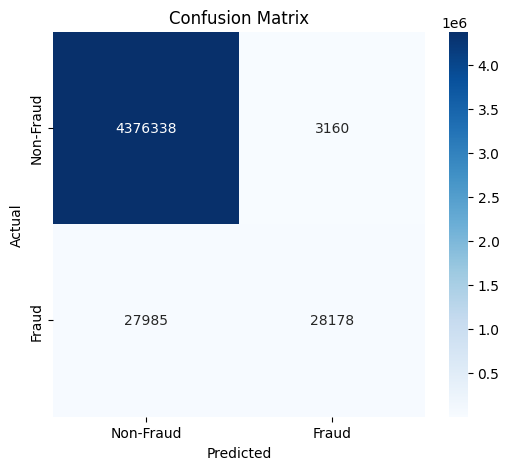

In [122]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
X_test = X_test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [124]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

y_pred = full_pipeline.predict(X_test)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Xác suất của lớp dương

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# In kết quả đánh giá
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9930
Precision: 0.8992
Recall: 0.5017
F1-Score: 0.6441
ROC AUC: 0.9976
Confusion Matrix:
[[4376338    3160]
 [  27985   28178]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


y_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Xác suất thuộc class 1 (fraud)

threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)


accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_proba)
cm        = confusion_matrix(y_test, y_pred)

print(f"Threshold: {threshold}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)


Threshold: 0.3
Accuracy:  0.9913
Precision: 0.6051
Recall:    0.9077
F1-Score:  0.7261
ROC AUC:   0.9976
Confusion Matrix:
[[4346234   33264]
 [   5186   50977]]


In [125]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')

Custom pAUC Score: 0.19840765752131226
AUC Score: 0.9976253020264586


In [ ]:
Features = [col for col in data.columns if col not in cols_to_drop]
print(Features)

['id_chiso', 'ma_ddo', 'bcs_chiso', 'hs_nhan', 'so_cto_chiso', 'chiso_cu', 'chiso_moi', 'san_luong', 'ma_ttcto', 'ngay_dky', 'ngay_cky', 'sluong_1', 'sluong_2', 'sluong_3', 'ma_tram', 'ma_cto', 'so_cto_hso_cto', 'ma_bdong', 'dong_dien', 'dien_ap', 'vh_cong', 'ma_cloai', 'ten_khang', 'ma_khang', 'dia_chi', 'csuat', 'so_cto_csuat_ddo']


C:\Users\HOME\AppData\Local\Temp\ipykernel_7716\514820566.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


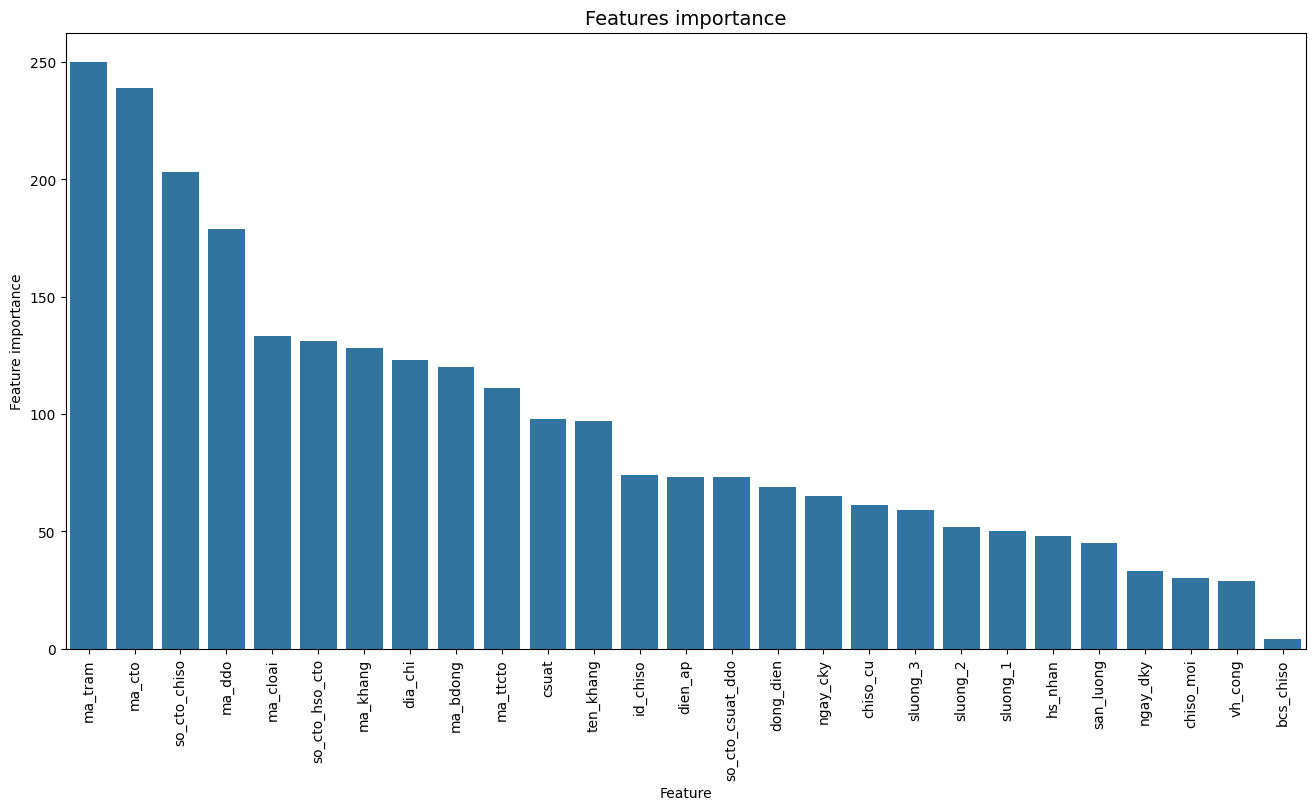

In [ ]:
tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
# model = LGBMClassifier(random_state=42)
# model.fit(X_train, y_train)

In [111]:
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

In [112]:
resample = ResampleTransformer(oversampler, undersampler)
X_train_res, y_train_res = resample.transform(X_train, y_train)
print(np.bincount(y_train_res))

[13138466   394154]


In [113]:
from lightgbm import early_stopping, log_evaluation
resample = ResampleTransformer(oversampler, undersampler)
X_train_res, y_train_res = resample.transform(X_train, y_train)


# === Train final model với early stopping trên tập validation ===


model = lgbm.LGBMClassifier(**lgb_params)

model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_train_res, y_train_res), (X_valid, y_valid)],
    eval_metric=['binary_logloss', 'binary_error'],
    callbacks=[
        lgbm.early_stopping(30),
        lgbm.log_evaluation(10)
    ]
)



Training until validation scores don't improve for 30 rounds
[10]	training's binary_logloss: 0.101763	training's binary_error: 0.0291262	valid_1's binary_logloss: 0.0600309	valid_1's binary_error: 0.0126619
[20]	training's binary_logloss: 0.0881471	training's binary_error: 0.0291262	valid_1's binary_logloss: 0.0532685	valid_1's binary_error: 0.0126619
[30]	training's binary_logloss: 0.0800071	training's binary_error: 0.0291108	valid_1's binary_logloss: 0.049042	valid_1's binary_error: 0.0126552
[40]	training's binary_logloss: 0.0730882	training's binary_error: 0.0273116	valid_1's binary_logloss: 0.0454515	valid_1's binary_error: 0.0118873
[50]	training's binary_logloss: 0.0676385	training's binary_error: 0.0266828	valid_1's binary_logloss: 0.0426064	valid_1's binary_error: 0.011651
[60]	training's binary_logloss: 0.0638311	training's binary_error: 0.0253481	valid_1's binary_logloss: 0.0405321	valid_1's binary_error: 0.0111873
[70]	training's binary_logloss: 0.0600651	training's binary_

LGBMClassifier(bagging_fraction=0.7738954452473223, bagging_freq=4,
               colsample_bynode=0.4025961355653304,
               colsample_bytree=0.8329551585827726,
               lambda_l1=0.08758718919397321, lambda_l2=0.0039689175176025465,
               learning_rate=0.03231007103195577, max_depth=4,
               min_data_in_leaf=85, n_estimators=1500, num_leaves=20,
               objective='binary', random_state=42, verbosity=-1)

In [114]:
evals_result = {}
evals_result = model.evals_result_


In [115]:

# Loss
train_loss = evals_result['training']['binary_logloss']
val_loss   = evals_result['valid_1']['binary_logloss']

# Accuracy = 1 - binary_error
train_acc = [1 - e for e in evals_result['training']['binary_error']]
val_acc   = [1 - e for e in evals_result['valid_1']['binary_error']]

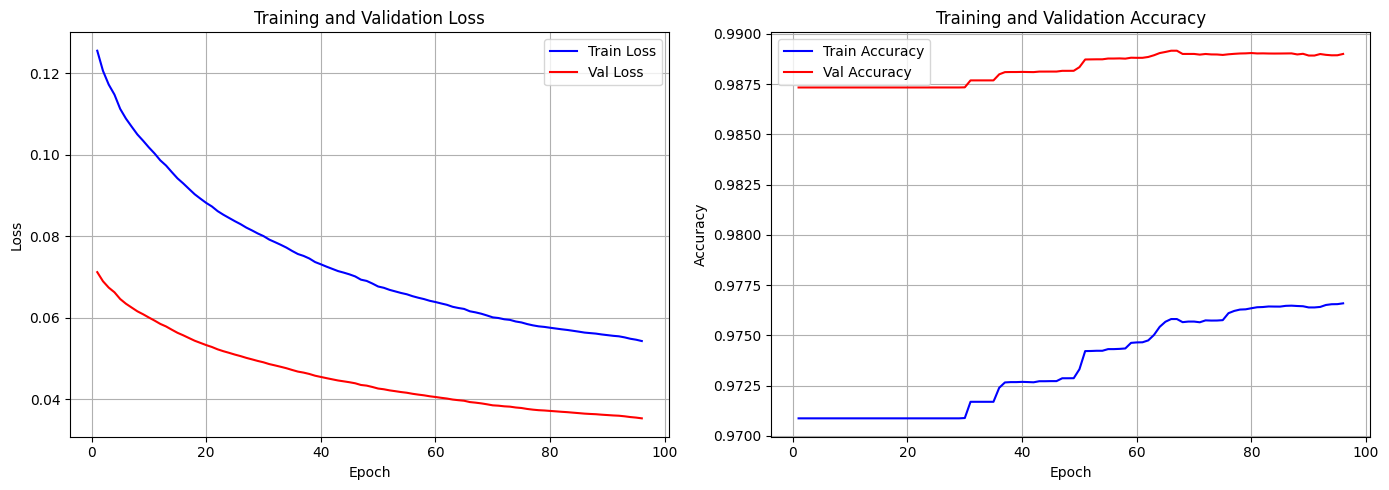

In [116]:
import matplotlib.pyplot as plt

# Epochs
epochs = range(1, len(train_loss) + 1)

# Vẽ
plt.figure(figsize=(14, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


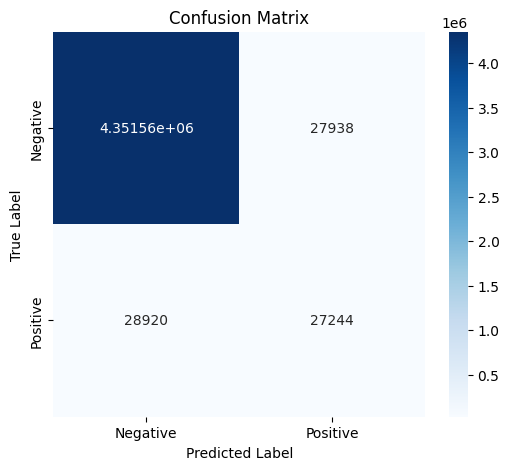

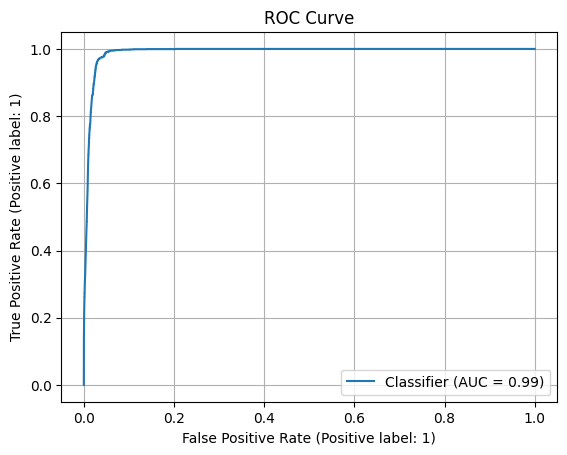

In [ ]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Tính toán lại confusion matrix nếu cần
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
conf_matrix = confusion_matrix(y_test, y_pred)

# Vẽ biểu đồ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Vẽ biểu đồ ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.grid(True)
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   4379497
           1       0.49      0.49      0.49     56164

    accuracy                           0.99   4435661
   macro avg       0.74      0.74      0.74   4435661
weighted avg       0.99      0.99      0.99   4435661



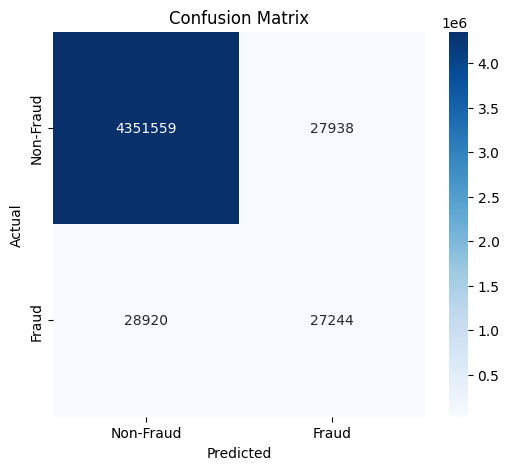

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
X_test = X_test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


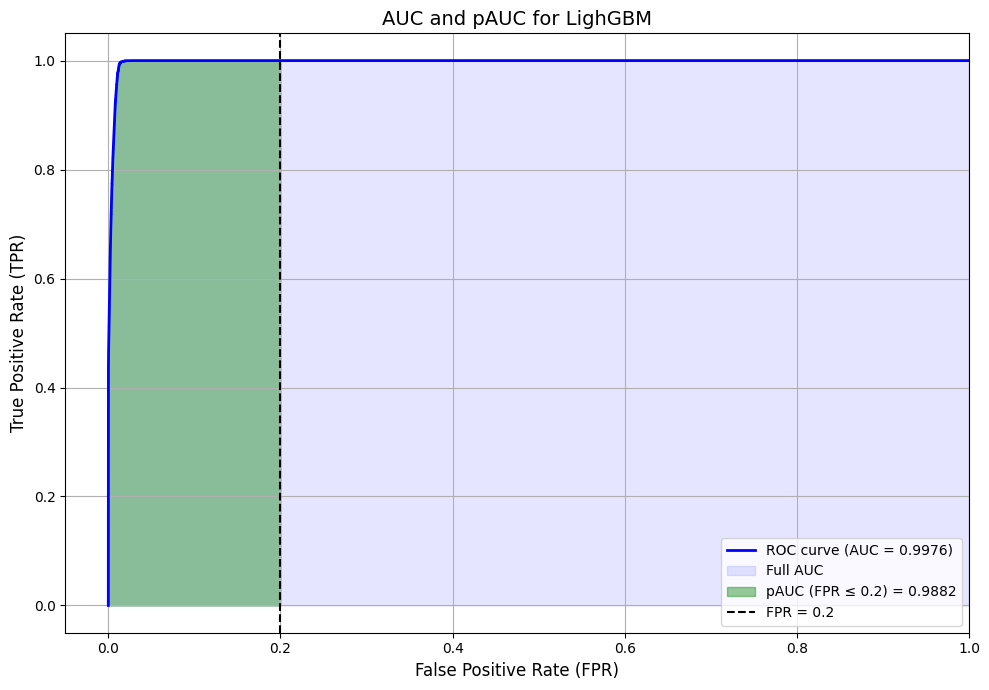

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dữ liệu đầu vào (đã train model)
y_true = y  # true labels
y_scores = full_pipeline.predict_proba(X)[:, 1]  # xác suất nhãn 1 (fraud)

# Tính ROC curve và AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Tính pAUC với FPR ≤ 0.2
max_fpr = 0.2
mask = fpr <= max_fpr
fpr_trunc = fpr[mask]
tpr_trunc = tpr[mask]

# Nội suy thêm điểm tại FPR = 0.2 nếu cần
if fpr_trunc[-1] < max_fpr and len(fpr_trunc) > 1:
    slope = (tpr_trunc[-1] - tpr_trunc[-2]) / (fpr_trunc[-1] - fpr_trunc[-2])
    tpr_at_02 = tpr_trunc[-1] + slope * (max_fpr - fpr_trunc[-1])
    fpr_trunc = np.append(fpr_trunc, max_fpr)
    tpr_trunc = np.append(tpr_trunc, tpr_at_02)

pauc = auc(fpr_trunc, tpr_trunc)
pauc_normalized = pauc / max_fpr

# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Full AUC background
plt.fill_between(fpr, tpr, alpha=0.1, color='blue', label='Full AUC')

# pAUC highlight
plt.fill_between(fpr_trunc, tpr_trunc, alpha=0.4, color='green',
                 label=f'pAUC (FPR ≤ {max_fpr}) = {pauc_normalized:.4f}')

# FPR = 0.2 line
plt.axvline(x=max_fpr, color='black', linestyle='--', label=f'FPR = {max_fpr}')

# Trang trí
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('AUC and pAUC for LighGBM', fontsize=14)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


preprocessing

Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.0353007
[200]	valid_0's binary_logloss: 0.0317721
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.0317721
AUC Score      : 0.99040
Custom pAUC    : 0.19439


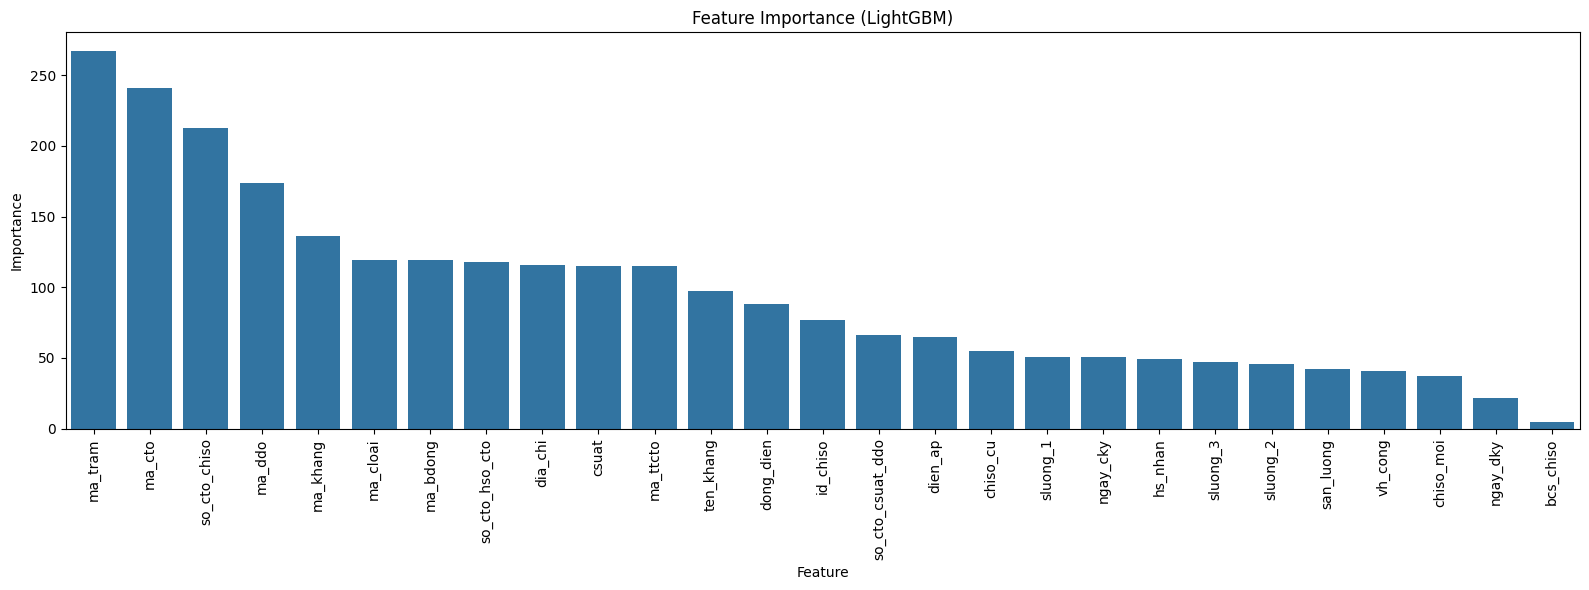

In [127]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm

# 1. Đọc dữ liệu
df_train = pd.read_parquet('trainn.parquet')
df_valid = pd.read_parquet('vali.parquet')
df_test  = pd.read_parquet('testt.parquet')

# 2. Cột loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# 4. Mã hóa object
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
X_valid[cat_cols] = oe.transform(X_valid[cat_cols].astype(str))
X_test[cat_cols] = oe.transform(X_test[cat_cols].astype(str))

# 5. Tham số LightGBM (không đổi)
SEED = 42 
lgb_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     SEED,
    'lambda_l1':        0.08758718919397321,
    'lambda_l2':        0.0039689175176025465,
    'learning_rate':    0.03231007103195577,
    'max_depth':        4,
    'num_leaves':       103,
    'colsample_bytree': 0.8329551585827726,
    'colsample_bynode': 0.4025961355653304,
    'bagging_fraction': 0.7738954452473223,
    'bagging_freq':     4,
    'min_data_in_leaf': 85,
    'scale_pos_weight': 2.7984184778875543,
    # 'device': 'gpu'
}

model = lgbm.LGBMClassifier(**lgb_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[
        lgbm.early_stopping(stopping_rounds=20),
        lgbm.log_evaluation(period=100)
    ]
)

# 6. Dự đoán
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 7. Custom pAUC
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    v_gt = abs(y_true - 1)
    v_pred = 1.0 - np.array(y_pred_proba)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / 0.5 * (partial_auc_scaled - 0.5)
    return partial_auc

# 8. In kết quả
print(f"AUC Score      : {roc_auc_score(y_test, y_pred_proba):.5f}")
print(f"Custom pAUC    : {custom_metric(y_test, y_pred_proba):.5f}")

# 9. Feature importance
features = X_train.columns
tmp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
tmp = tmp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(x='Feature', y='Importance', data=tmp)
plt.xticks(rotation=90)
plt.title('Feature Importance (LightGBM)')
plt.tight_layout()
plt.show()


In [ ]:
evals_result = {}
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=["Train", "Valid"],
    eval_metric="binary_logloss",  # hoặc "auc"
    callbacks=[
        lgbm.early_stopping(20),
        lgbm.log_evaluation(0),
        lgbm.record_evaluation(evals_result)
    ]
)

# Vẽ biểu đồ từ evals_result
plt.figure(figsize=(14, 5))
plt.plot(evals_result["Train"]["binary_logloss"], label="Train Loss", color='blue')
plt.plot(evals_result["Valid"]["binary_logloss"], label="Val Loss", color='red')
plt.title("Training and Validation Loss (LightGBM)")
plt.xlabel("Epoch")
plt.ylabel("LogLoss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


phan cu

In [ ]:
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang',
    'ngay_hhluc_vitri_ddo',
    'ngay_hhluc_diemdo',
    'ngay_hhluc',
    'id_bcs',
    'ngay_kdinh',
    'loai_chiso',
    'ngay_hluc_diem_do',
    'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo',
    'ngay_hluc_khang',
    'gia_tri',
    'loai_giatri',
    'kimua_cspk',
    'id_ddo',
    'ma_dviqly',
    'so_cot',
    'so_hop',
    'ma_dvictren',
    'ky',
    'thang',
    'nam',
    'sluong_ttiep',
    'sluong_trphu',
    'thd_le',
    'ma_cnang_chiso',
    'ngay_bdong',
    'id_khang',
    'so_pha',
    'ngay_tao_chiso',
    'nguoi_tao_chiso',
    'ngay_sua_chiso',
    'nguoi_sua_chiso',
    'ngay_hluc'

]

X = data.drop(columns=cols_to_drop)
y = data['fraud']



X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
# Tính tỉ lệ lớp Fraud trong tập train và test
train_ratio = y_train.mean()
test_ratio = y_test.mean()

print(f"Tỉ lệ Fraud trong tập TRAIN: {train_ratio:.4f} ({train_ratio*100:.2f}%)")
print(f"Tỉ lệ Fraud trong tập TEST:  {test_ratio:.4f} ({test_ratio*100:.2f}%)")

# Tính tỷ lệ lớp trong tập huấn luyện và tập kiểm tra
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

print("Tỉ lệ các lớp trong tập TRAIN:")
print(train_class_distribution)
print("\nTỉ lệ các lớp trong tập TEST:")
print(test_class_distribution)
